<a href="https://colab.research.google.com/github/nicole-whitlock/games/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install scikit-learn nltk pandas numpy matplotlib seaborn
!pip install stop-words
!pip install joblib

  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32894 sha256=8fa6c1cd4ec8a3c992a026cf222f87dd0bee264757bfa0658468263fb5d59b31
  Stored in directory: /root/.cache/pip/wheels/8f/a5/51/a5405e1da5d178491b79d12cc81b6cb9bb14fe2c8c632eba70
Successfully built stop-words


In [13]:


import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import re
from stop_words import get_stop_words

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Load data
df = pd.read_csv('/content/metacritic_english_reviews.csv')


Creating 3 sentiment labels (positive/neutral/negative) from scores...

Sentiment distribution:
sentiment
positive    1001907
negative     281432
neutral      196906
Name: count, dtype: int64


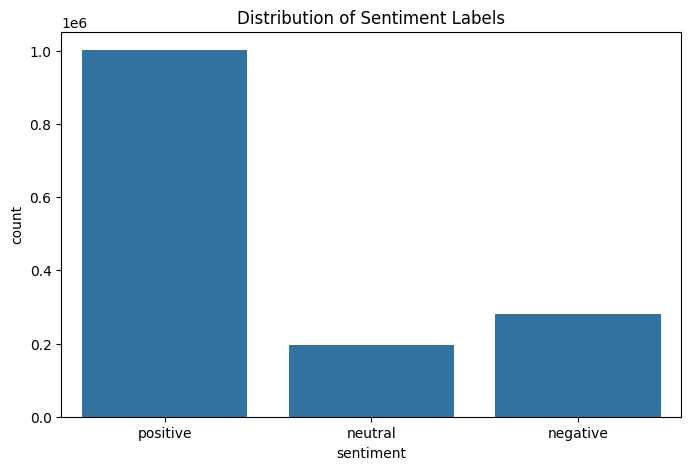

In [8]:
# Create 3 Sentiment Labels
print("\nCreating 3 sentiment labels (positive/neutral/negative) from scores...")

# Convert scores to numerical
if df['score'].dtype == object:
    df['score'] = df['score'].str.extract('(\d+)').astype(float)

# Create 3 sentiment categories
df['sentiment'] = np.where(
    df['score'] >= 70, 'positive',
    np.where(df['score'] <= 40, 'negative', 'neutral')
)

print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Visualize distribution
plt.figure(figsize=(8,5))
sns.countplot(x='sentiment', data=df, order=['positive', 'neutral', 'negative'])
plt.title('Distribution of Sentiment Labels')
plt.show()



In [18]:
stop_words = list(get_stop_words('en'))         #About 900 stopwords
nltk_words = list(stopwords.words('english')) #About 150 stopwords
stop_words.extend(nltk_words)

stop_words.append('game')

In [19]:
# Text Preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    words = text.split()
    # Remove stopwords

    words = [word for word in words if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

print("\nPreprocessing text...")
df['processed_text'] = df['quote'].apply(preprocess_text)


Preprocessing text...


In [16]:
from collections import Counter

word_counts = Counter()

for quote in df['processed_text']:
    words = re.findall(r'\b\w+\b', str(quote))
    word_counts.update(words)

# View most common words
print(word_counts.most_common(10))

[('game', 3088556), ('like', 601286), ('one', 478833), ('story', 463521), ('good', 436506), ('time', 430308), ('play', 396951), ('great', 361015), ('get', 360671), ('really', 347995)]


In [20]:

# Train-Test Split
X = df['processed_text']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Preserve class distribution
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")


Training samples: 1184196
Test samples: 296049


In [21]:
print("\nVectorizing text data...")
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=5,            # Ignore rare terms
    max_df=0.7           # Ignore overly common terms
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



Vectorizing text data...


In [22]:
# Model Training
print("\nTraining 3-class classifier...")
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handles class imbalance
    C=1.0,                   # Regularization strength
    multi_class='multinomial' # For 3+ classes
)
model.fit(X_train_vec, y_train)


Training 3-class classifier...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial')


Detailed Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.78      0.76     56286
     neutral       0.37      0.66      0.48     39381
    positive       0.94      0.79      0.86    200382

    accuracy                           0.77    296049
   macro avg       0.69      0.74      0.70    296049
weighted avg       0.83      0.77      0.79    296049



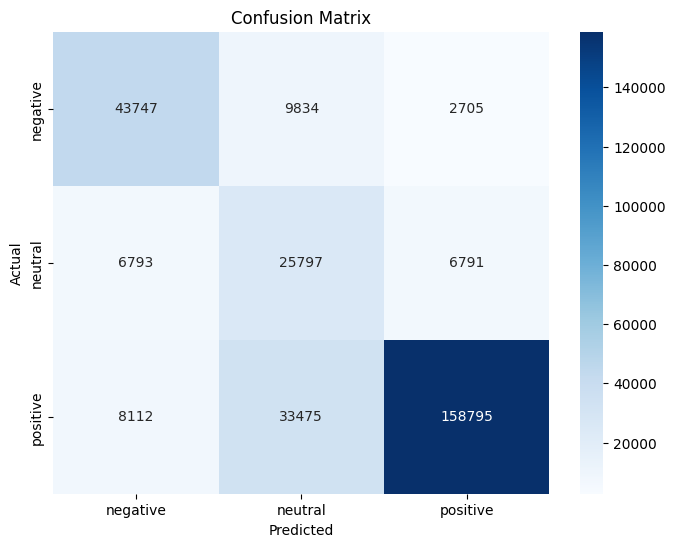

In [23]:
# Evaluation
y_pred = model.predict(X_test_vec)

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Prediction Function
def predict_sentiment(text):
    processed = preprocess_text(text)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)[0]
    probabilities = model.predict_proba(vectorized)[0]
    return prediction, probabilities

# Example Predictions
test_reviews = [
    "This game revolutionized the genre with incredible innovation",
    "The gameplay is average, neither good nor bad",
    "Broken mess that crashes every 10 minutes",
    "Visually stunning but the story is just okay",
    "Waste of money, completely unplayable"
]

print("\nExample Predictions:")
for review in test_reviews:
    pred, probs = predict_sentiment(review)
    print(f"\nReview: '{review}'")
    print(f"Predicted: {pred}")
    print("Probabilities:")
    for class_name, prob in zip(model.classes_, probs):
        print(f"  {class_name}: {prob:.2f}")


Example Predictions:

Review: 'This game revolutionized the genre with incredible innovation'
Predicted: positive
Probabilities:
  negative: 0.01
  neutral: 0.07
  positive: 0.92

Review: 'The gameplay is average, neither good nor bad'
Predicted: neutral
Probabilities:
  negative: 0.03
  neutral: 0.96
  positive: 0.00

Review: 'Broken mess that crashes every 10 minutes'
Predicted: negative
Probabilities:
  negative: 0.98
  neutral: 0.02
  positive: 0.00

Review: 'Visually stunning but the story is just okay'
Predicted: neutral
Probabilities:
  negative: 0.09
  neutral: 0.66
  positive: 0.24

Review: 'Waste of money, completely unplayable'
Predicted: negative
Probabilities:
  negative: 1.00
  neutral: 0.00
  positive: 0.00


In [ ]:











joblib.dump(model, '3class_sentiment_model.pkl')
joblib.dump(vectorizer, '3class_tfidf_vectorizer.pkl')
print("\nSaved model and vectorizer")


